# chroma key

In [1]:
import numpy             as np
import cv2               as cv
import skimage           as si
import matplotlib.pyplot as plt
import ipywidgets
from matplotlib.pyplot import imshow, subplot, title

%matplotlib inline

In [2]:
def fig(w,h):
    return plt.figure(figsize=(w,h))

def readrgb(file):
    return cv.cvtColor( cv.imread("../images/"+file), cv.COLOR_BGR2RGB) 

def rgb2yuv(x):
    return cv.cvtColor(x,cv.COLOR_RGB2YUV)

def yuv2rgb(x):
    return cv.cvtColor(x,cv.COLOR_YUV2RGB)

## chroma

Vamos a implementar el efecto típico de composición de imágenes [chroma key](https://en.wikipedia.org/wiki/Chroma_key)

Necesitamos una imagen de fondo ("*background*"). Si tuviéramos un fondo uniforme de color muy distinto al objeto sería más fácil. Pero vamos a trabajar con cualquier escena. Por ejemplo:

(480, 640)


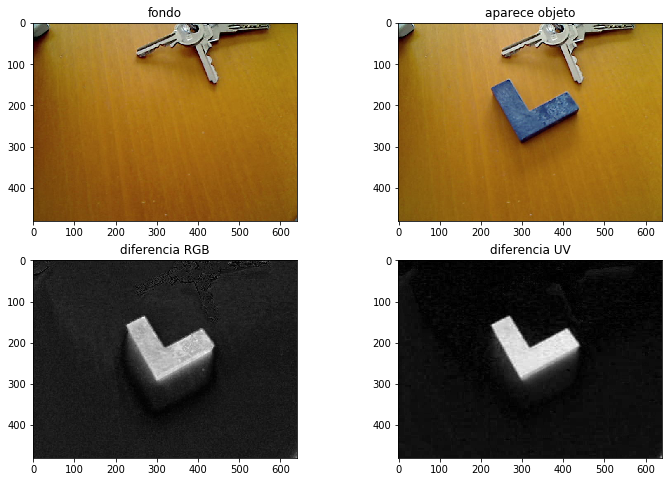

In [3]:
back = readrgb("ss0.png")
obj  = readrgb("ss1.png")
dst  = readrgb("coins.png")

# diferencia de imágenes en el espacio RGB
drgb = np.sum(abs(obj.astype(float)-back.astype(float)),axis=2)

backyuv = rgb2yuv(back)
objyuv  = rgb2yuv(obj)

# paso a float y selecciono canales UV
obuv = objyuv.astype(float)[:,:,[1,2]]
bkuv = backyuv.astype(float)[:,:,[1,2]]

# diferencia de imágenes en el espacio UV
duv = np.sum(abs(obuv-bkuv),axis=2)

print(duv.shape)

fig(12,8)
plt.set_cmap('gray')
subplot(2,2,1); imshow(back); title('fondo')
subplot(2,2,2); imshow(obj); title('aparece objeto')
subplot(2,2,3); imshow(drgb); title('diferencia RGB')
subplot(2,2,4); imshow(duv); title('diferencia UV');

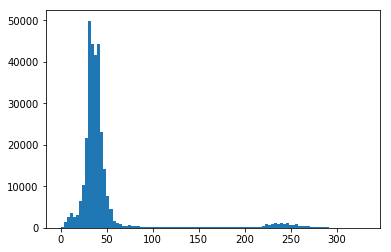

In [4]:
plt.hist(drgb.flatten(),100);

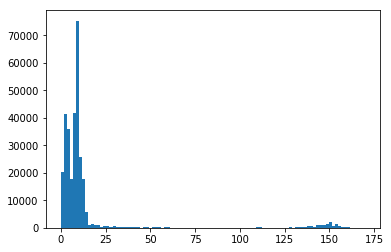

In [5]:
plt.hist(duv.flatten(),100);

Vemos que las diferencias entre las imágenes están un poco más separadas en el espacio UV, que tiene en cuenta solo el color, independientemente de la intensidad de luz. En este ejemplo la separación es muy buena en los dos casos, pero en general el espacio UV puede ayudar a que, por ejemplo, las sombras no influyan mucho.

El punto de corte para separar las zonas donde realmente está el objeto se elige a ojo mirando el histograma, en un valor que esté en el valle entre los valores de diferencia bajos y altos. (Más adelante estudiaremos el umbralizado automático.)

El aspecto que tendrá la "máscara" de selección del objeto (imagen booleana que indica los píxels que pertencen al objeto) se puede mostrar de forma interactiva para cualquier umbral de corte usando la función "interactive":

In [6]:
# >jupyter nbextension enable --sys-prefix --py widgetsnbextension

def fun(h):
    imshow(drgb>h)

ipywidgets.interactive(fun, h=(0,350))    

interactive(children=(IntSlider(value=175, description='h', max=350), Output()), _dom_classes=('widget-interact',))

Finalmente creamos la máscara con el umbral deseado y copiamos solo esos pixels a la imagen de destino (que debe ser del mismo tamaño).

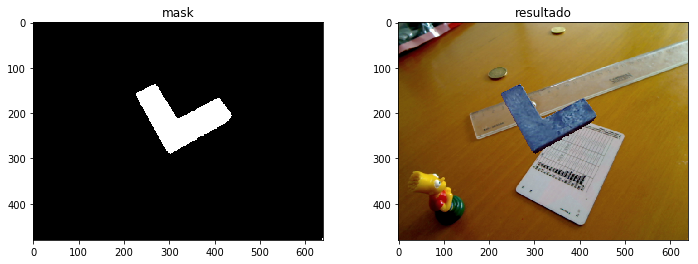

In [7]:
#mask = drgb > 150
mask = duv > 90

r,c = mask.shape

fig(12,4)
subplot(1,2,1); imshow(mask); title('mask');

res = cv.resize(dst,(c,r))

# hay que convertir la mask a 3 canales para poder copiar rgb
mask3 = mask.reshape(r,c,1)

np.copyto(res,obj, where = mask3) 
subplot(1,2,2); imshow(res); title('resultado');

## misc
 
- background subtraction (mog2)